In [1]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle
import pickle
from PIL import Image
import urllib
import mplcyberpunk

In [2]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [3]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640962/Live/England-Premier-League-2022-2023-Fulham-Wolverhampton"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640962


In [4]:
score = score.replace('*', '')

In [5]:
homeID = home_data['teamId']
awayID = away_data['teamId']

## Colours 

In [6]:
home_colors = {
    'Arsenal': '#E63636',
    'Aston Villa' : '#811331',
    'Brentford' : '#E63636', 
    'Bournemouth' : '#E63636',
    'Brighton': '#2d8ce7',
    'Chelsea' : '#2D5DE7',
    'Crystal Palace' : '#E63636',
    'Everton' : '#2D5DE7', 
    'Fulham' : '#9C9C9C', 
    'Leeds' : '#9C9C9C', 
    'Leicester' : '#2d8ce7',
    'Liverpool' : '#E63636',
    'Nottingham Forest' : '#E63636',
    'Newcastle' : '#9C9C9C',
    'Man Utd' : '#E63636',
    'Man City' : '#6FC6E6',
    'Southampton' : '#E63636',
    'Tottenham' : '#9C9C9C', 
    'West Ham' : '#811331',
    'Wolves' : '#DA9D0A'
}

away_colors = {
    'Arsenal': '#757474',
    'Aston Villa' : '#6FC6E6',
    'Brentford' : '#6FC6E6', 
    'Bournemouth' : '#757474',
    'Brighton': '#FB6B07',
    'Chelsea' : '#C5C5AD',
    'Crystal Palace' : '#9C9C9C', 
    'Everton' : '#C571FA', 
    'Fulham' : '#5FE347', 
    'Leeds' : '#b4b400', 
    'Leicester' : '#757474',
    'Liverpool' : '#9C9C9C', 
    'Nottingham Forest' : '#b4b400',
    'Newcastle' : '#0202C4',
    'Man Utd' : '#9C9C9C',
    'Man City' : '#757474',
    'Southampton' : '#2d8ce7',
    'Tottenham' : '#C571FA', 
    'West Ham' : '#757474',
    'Wolves' : '#066D49'
}

In [7]:
home_color = home_colors[home_name]
away_color = home_colors[away_name]

if (home_color == away_color) or (home_color == '#6FC6E6' and away_color == '#2d8ce7') or (home_color == '#2d8ce7' and away_color == '#6FC6E6') or (home_color == '#E63636' and away_color == '#811331') or (home_color == '#811331' and away_color == '#E63636'):
    away_color = away_colors[away_name]


## Logos 

In [8]:
logos = {
    'Arsenal': 9825,
    'Aston Villa' : 10252,
    'Brentford' : 9937, 
    'Bournemouth' : 8678, 
    'Brighton': 10204,
    'Chelsea' : 8455,
    'Crystal Palace' : 9826, 
    'Everton' : 8668, 
    'Fulham' : 9879, 
    'Leeds' : 8463, 
    'Leicester' : 8197,
    'Liverpool' : 8650,
    'Nottingham Forest' : 10203,
    'Newcastle' : 10261,
    'Man Utd' : 10260,
    'Man City' : 8456,
    'Southampton' : 8466,
    'Tottenham' : 8586, 
    'West Ham' : 8654,
    'Wolves' : 8602
}

home_logo_code = logos[home_name]
away_logo_code = logos[away_name]

## XG Model
- Run shot data through our xG model, so we can get the xA and xG for individual players (and how they rank relative to distribution)
- First run through function which reduces it to the necessary form (described in detail in our xG model notebook)

In [9]:
pitch_length_x = 100
pitch_length_y = 100

feature_cols = ['id',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
                'shotCounter', 
#                 'shotDirectCorner',
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
#                 'shotLongPass',
#                 'shotShortPass',
#                 'shotCross',
#                 'shotThroughBall',
                'bigChanceScored',
                'bigChanceMissed'
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]


def shotData(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]
#     df_shots['shotTakeOn'] = df_shots['prevEvent'] == 'TakeOn'
#     df_shots['shotDefensiveAction'] = df_shots['prevEvent'].isin(['Challenge', 'Tackle', 'Interception', 'Clearance',
#                                                                   'BallRecovery', 'BlockedPass'])

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    # Add Big Chance Column
    df_shots['bigChance'] = df_shots['bigChanceMissed'] | df_shots['bigChanceScored']
    df_shots = df_shots.drop(['bigChanceMissed', 'bigChanceScored'], axis=1)

    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
#             'shotDirectCorner',
            'shotCounter',
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
#             'shotTakeOn', 
#             'shotDefensiveAction',
            'bigChance'
           ]
    df_shots[cat_cols] *= 1
    
    obj_cols = [
#             'shotLongPass',
#             'shotShortPass',
#             'shotCross',
#             'shotThroughBall',
             ]
    
    for col in obj_cols:
        df_shots[col] = pd.to_numeric(df_shots[col])
    

    return df_shots 

In [10]:
data = shotData(events_df).reset_index(drop=True)
X_game = data.iloc[:, 10:]
Y_game = data['isGoal']

In [11]:
data

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,shotRightFoot,shotLeftFoot,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance
0,2.511639e+09,161,161.0,88.6,43.5,Pablo Sarabia,Nélson Semedo,19,58.0,False,0,1,0,1,0,0,57.638616,6.5,29.690727,0
1,2.511641e+09,170,170.0,73.2,32.2,Kenny Tete,Harrison Reed,21,57.0,False,1,0,0,1,0,0,72.904595,17.8,33.591282,0
2,2.511642e+09,161,161.0,90.7,40.9,Pablo Sarabia,Raúl Jiménez,22,44.0,True,1,0,0,1,0,0,59.827251,9.1,44.377244,0
3,2.511650e+09,161,161.0,56.9,68.3,Matheus Cunha,Pablo Sarabia,33,28.0,False,1,0,0,1,0,0,53.502336,18.3,23.005784,0
4,2.511651e+09,170,170.0,73.8,60.8,João Palhinha,Andreas Pereira,34,5.0,False,1,0,0,1,0,0,47.149549,10.8,22.402130,0
5,2.511652e+09,170,170.0,90.2,43.3,Carlos Vinícius,Bobby De Cordova-Reid,36,22.0,False,0,0,1,1,0,0,57.540681,6.7,34.359380,1
6,2.511655e+09,161,161.0,90.7,48.7,Rúben Neves,Matheus Nunes,39,23.0,False,0,0,1,1,0,0,52.136168,1.3,7.957525,0
7,2.511658e+09,170,170.0,86.3,30.5,Kenny Tete,Bobby De Cordova-Reid,42,22.0,False,1,0,0,1,0,0,70.837419,19.5,54.909500,0
8,2.511662e+09,170,161.0,72.3,53.0,Andreas Pereira,Mario Lemina,47,52.0,False,1,0,0,0,1,0,54.555385,3.0,6.181226,0
9,2.511674e+09,170,170.0,75.8,30.3,João Palhinha,Willian,46,26.0,False,1,0,0,1,0,0,73.781637,19.7,39.147298,0


In [12]:
# Import our xG model 
xg_model = pickle.load(open('xgModel_XGBoost22.sav', 'rb'))

In [13]:
y_pred_game = xg_model.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)
df_pred_game

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.511639e+09,161,161.0,88.6,43.5,Pablo Sarabia,Nélson Semedo,19,58.0,False,...,0,1,0,0,57.638616,6.5,29.690727,0,0.919376,0.080624
1,2.511641e+09,170,170.0,73.2,32.2,Kenny Tete,Harrison Reed,21,57.0,False,...,0,1,0,0,72.904595,17.8,33.591282,0,0.995229,0.004771
2,2.511642e+09,161,161.0,90.7,40.9,Pablo Sarabia,Raúl Jiménez,22,44.0,True,...,0,1,0,0,59.827251,9.1,44.377244,0,0.908635,0.091365
3,2.511650e+09,161,161.0,56.9,68.3,Matheus Cunha,Pablo Sarabia,33,28.0,False,...,0,1,0,0,53.502336,18.3,23.005784,0,0.996502,0.003498
4,2.511651e+09,170,170.0,73.8,60.8,João Palhinha,Andreas Pereira,34,5.0,False,...,0,1,0,0,47.149549,10.8,22.402130,0,0.984707,0.015293
5,2.511652e+09,170,170.0,90.2,43.3,Carlos Vinícius,Bobby De Cordova-Reid,36,22.0,False,...,1,1,0,0,57.540681,6.7,34.359380,1,0.855859,0.144141
6,2.511655e+09,161,161.0,90.7,48.7,Rúben Neves,Matheus Nunes,39,23.0,False,...,1,1,0,0,52.136168,1.3,7.957525,0,0.970475,0.029525
7,2.511658e+09,170,170.0,86.3,30.5,Kenny Tete,Bobby De Cordova-Reid,42,22.0,False,...,0,1,0,0,70.837419,19.5,54.909500,0,0.976983,0.023017
8,2.511662e+09,170,161.0,72.3,53.0,Andreas Pereira,Mario Lemina,47,52.0,False,...,0,0,1,0,54.555385,3.0,6.181226,0,0.955004,0.044996
9,2.511674e+09,170,170.0,75.8,30.3,João Palhinha,Willian,46,26.0,False,...,0,1,0,0,73.781637,19.7,39.147298,0,0.991326,0.008674


In [14]:
xg_moving = df_pred_game[['teamId', 'minute', 'prob_goal', 'isGoal']]

# Add Penalites manually
pens_scored = events_df[(events_df['penaltyScored'] == True)][['teamId', 'minute']].reset_index(drop=True)
pens_missed = events_df[(events_df['penaltyMissed'] == True)][['teamId', 'minute']].reset_index(drop=True)

for i in range(len(pens_scored)):
    team = pens_scored['teamId'][i]
    minute = pens_scored['minute'][i]
    xg_moving.loc[len(xg_moving)+1] = [team, minute, 0.75, True]
    

for i in range(len(pens_missed)):
    team = pens_missed['teamId'][i]
    minute = pens_missed['minute'][i]
    xg_moving.loc[len(xg_moving)+1] = [team, minute, 0.75, False]
    
xg_moving = xg_moving.sort_values(by='minute').reset_index(drop=True)


xg_moving['cumSum'] = ''
prev_h = 0
prev_a = 0

for i, row in xg_moving.iterrows():
    if xg_moving['teamId'][i] == homeID:
        xg_moving['cumSum'][i] = prev_h + xg_moving['prob_goal'][i]
        prev_h = xg_moving['cumSum'][i]
    else:
        xg_moving['cumSum'][i] = prev_a + xg_moving['prob_goal'][i]
        prev_a = xg_moving['cumSum'][i]


In [15]:
xg_moving_h = xg_moving[xg_moving['teamId'] == homeID].reset_index(drop=True)
xg_moving_a = xg_moving[xg_moving['teamId'] == awayID].reset_index(drop=True)


In [16]:
xg_moving_h

,teamId,minute,prob_goal,isGoal,cumSum
0,170,21,0.004771,False,0.004771
1,170,34,0.015293,False,0.020064
2,170,36,0.144141,False,0.164205
3,170,42,0.023017,False,0.187222
4,170,46,0.008674,False,0.195896
5,170,47,0.044996,False,0.240891
6,170,54,0.029598,False,0.270489
7,170,63,0.030125,True,0.300614
8,170,71,0.012898,False,0.313512
9,170,93,0.346071,False,0.659583


In [17]:
minute = xg_moving_h.loc[0]['minute']
xg_moving_h.loc[-1] = [homeID, minute-1, 0, False, 0]
xg_moving_h.loc[-2] = [homeID, 0, 0, False, 0]
xg_moving_h.index = xg_moving_h.index + 2
xg_moving_h = xg_moving_h.sort_index() 
xg_moving_h

minute = xg_moving_a.loc[0]['minute']
xg_moving_a.loc[-1] = [awayID, minute-1, 0, False, 0]
xg_moving_a.loc[-2] = [awayID, 0, 0, False, 0]
xg_moving_a.index = xg_moving_a.index + 2  
xg_moving_a = xg_moving_a.sort_index() 
xg_moving_a

,teamId,minute,prob_goal,isGoal,cumSum
0,161,0,0.000000,False,0
1,161,18,0.000000,False,0
2,161,19,0.080624,False,0.080624
3,161,22,0.091365,True,0.171989
4,161,33,0.003498,False,0.175487
5,161,39,0.029525,False,0.205012
6,161,48,0.084683,False,0.289695
7,161,51,0.172105,False,0.4618
8,161,61,0.032597,False,0.494397
9,161,66,0.022074,False,0.516471


In [18]:
full_time = events_df['minute'].max()
home_xg_final = xg_moving_h.loc[len(xg_moving_h)-1]['cumSum']
xg_moving_h.loc[len(xg_moving_h)] = [homeID, full_time, 0, False, home_xg_final]
xg_moving_h

away_xg_final = xg_moving_a.loc[len(xg_moving_a)-1]['cumSum']
xg_moving_a.loc[len(xg_moving_a)] = [awayID, full_time, 0, False, away_xg_final]
xg_moving_a

,teamId,minute,prob_goal,isGoal,cumSum
0,161,0,0.000000,False,0
1,161,18,0.000000,False,0
2,161,19,0.080624,False,0.080624
3,161,22,0.091365,True,0.171989
4,161,33,0.003498,False,0.175487
5,161,39,0.029525,False,0.205012
6,161,48,0.084683,False,0.289695
7,161,51,0.172105,False,0.4618
8,161,61,0.032597,False,0.494397
9,161,66,0.022074,False,0.516471


In [19]:
home_goals = xg_moving_h[xg_moving_h['isGoal'] == True].reset_index(drop=True)
away_goals = xg_moving_a[xg_moving_a['isGoal'] == True].reset_index(drop=True)
home_goals

,teamId,minute,prob_goal,isGoal,cumSum
0,170,63,0.030125,True,0.300614


## Metrics 

In [20]:
metrics = []

## xG

In [21]:
home_xg = round(xg_moving_h['cumSum'][len(xg_moving_h)-1],2)
away_xg = round(xg_moving_a['cumSum'][len(xg_moving_a)-1],2)
metrics.append(['xg', home_xg, away_xg])

## Expected Points and Win Prob
- Assuming Poisson distribution here 
- Just running 1,000,000 scenarios and looking at the outcomes

In [22]:
sims = 1000000

home_wins = 0
away_wins = 0
draws = 0

for _ in range(sims):
    home_goals_sim = np.random.poisson(home_xg)
    away_goals_sim = np.random.poisson(away_xg)
    
    if home_goals_sim > away_goals_sim:
        home_wins += 1
        
    if away_goals_sim > home_goals_sim:
        away_wins += 1
        
    if home_goals_sim == away_goals_sim:
        draws += 1
        
        
home_win_prob = home_wins/sims
away_win_prob = away_wins/sims
draw_prob = draws/sims

In [23]:
home_xp = (home_win_prob*3) + (draw_prob*1)
away_xp = (away_win_prob*3) + (draw_prob*1)

In [24]:
metrics.append(['xPts', round(home_xp,2), round(away_xp,2)])
metrics.append(['Win Probability', str(int(home_win_prob*100))+'%', str(int(away_win_prob*100))+'%'])

## Big Chances  

In [25]:
home_bc = len(xg_moving_h[xg_moving_h['prob_goal'] > 0.275])
away_bc = len(xg_moving_a[xg_moving_a['prob_goal'] > 0.275])
metrics.append(['Big Chances', home_bc, away_bc])

In [26]:
df_pred_game

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.511639e+09,161,161.0,88.6,43.5,Pablo Sarabia,Nélson Semedo,19,58.0,False,...,0,1,0,0,57.638616,6.5,29.690727,0,0.919376,0.080624
1,2.511641e+09,170,170.0,73.2,32.2,Kenny Tete,Harrison Reed,21,57.0,False,...,0,1,0,0,72.904595,17.8,33.591282,0,0.995229,0.004771
2,2.511642e+09,161,161.0,90.7,40.9,Pablo Sarabia,Raúl Jiménez,22,44.0,True,...,0,1,0,0,59.827251,9.1,44.377244,0,0.908635,0.091365
3,2.511650e+09,161,161.0,56.9,68.3,Matheus Cunha,Pablo Sarabia,33,28.0,False,...,0,1,0,0,53.502336,18.3,23.005784,0,0.996502,0.003498
4,2.511651e+09,170,170.0,73.8,60.8,João Palhinha,Andreas Pereira,34,5.0,False,...,0,1,0,0,47.149549,10.8,22.402130,0,0.984707,0.015293
5,2.511652e+09,170,170.0,90.2,43.3,Carlos Vinícius,Bobby De Cordova-Reid,36,22.0,False,...,1,1,0,0,57.540681,6.7,34.359380,1,0.855859,0.144141
6,2.511655e+09,161,161.0,90.7,48.7,Rúben Neves,Matheus Nunes,39,23.0,False,...,1,1,0,0,52.136168,1.3,7.957525,0,0.970475,0.029525
7,2.511658e+09,170,170.0,86.3,30.5,Kenny Tete,Bobby De Cordova-Reid,42,22.0,False,...,0,1,0,0,70.837419,19.5,54.909500,0,0.976983,0.023017
8,2.511662e+09,170,161.0,72.3,53.0,Andreas Pereira,Mario Lemina,47,52.0,False,...,0,0,1,0,54.555385,3.0,6.181226,0,0.955004,0.044996
9,2.511674e+09,170,170.0,75.8,30.3,João Palhinha,Willian,46,26.0,False,...,0,1,0,0,73.781637,19.7,39.147298,0,0.991326,0.008674


## Box Shots 

In [27]:
pens_h_count = len(pens_scored[pens_scored['teamId'] == homeID]) + len(pens_missed[pens_missed['teamId'] == homeID])
pens_a_count = len(pens_scored[pens_scored['teamId'] == awayID]) + len(pens_missed[pens_missed['teamId'] == awayID])

In [28]:
home_boxshots = len(df_pred_game[(df_pred_game['teamId'] == homeID) & 
                   (df_pred_game['x'] >= 83) & 
                   (df_pred_game['y'] >= 21.1) & 
                   (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) + pens_h_count


away_boxshots = len(df_pred_game[(df_pred_game['teamId'] == awayID) & 
                   (df_pred_game['x'] >= 83) & 
                   (df_pred_game['y'] >= 21.1) & 
                   (df_pred_game['y'] <= 78.9)].reset_index(drop=True)) + pens_a_count
metrics.append(['Box Shots', home_boxshots, away_boxshots])
metrics

[['xg', 0.66, 0.52],
 ['xPts', 1.42, 1.15],
 ['Win Probability', '33%', '24%'],
 ['Big Chances', 1, 0],
 ['Box Shots', 3, 6]]

In [29]:
df_pred_game[df_pred_game['teamId'] == awayID]

,id,teamId,prevTeam,x,y,playerName,playerAssist,minute,second,isGoal,...,shotHead,shotOpenPlay,shotSetPiece,shotCounter,distance_to_goal,distance_to_center,angle,bigChance,prob_no_goal,prob_goal
0,2.511639e+09,161,161.0,88.6,43.5,Pablo Sarabia,Nélson Semedo,19,58.0,False,...,0,1,0,0,57.638616,6.5,29.690727,0,0.919376,0.080624
2,2.511642e+09,161,161.0,90.7,40.9,Pablo Sarabia,Raúl Jiménez,22,44.0,True,...,0,1,0,0,59.827251,9.1,44.377244,0,0.908635,0.091365
3,2.511650e+09,161,161.0,56.9,68.3,Matheus Cunha,Pablo Sarabia,33,28.0,False,...,0,1,0,0,53.502336,18.3,23.005784,0,0.996502,0.003498
6,2.511655e+09,161,161.0,90.7,48.7,Rúben Neves,Matheus Nunes,39,23.0,False,...,1,1,0,0,52.136168,1.3,7.957525,0,0.970475,0.029525
10,2.511676e+09,161,161.0,92.2,54.8,Maximilian Kilman,Rúben Neves,48,47.0,False,...,1,0,1,0,45.868072,4.8,31.607502,0,0.915317,0.084683
11,2.511677e+09,161,161.0,90.3,54.2,Raúl Jiménez,Pablo Sarabia,51,21.0,False,...,1,1,0,0,46.815916,4.2,23.412114,1,0.827895,0.172105
13,2.511682e+09,161,161.0,74.2,55.4,Mario Lemina,Matheus Nunes,61,26.0,False,...,0,1,0,0,51.524751,5.4,11.821488,0,0.967403,0.032597
15,2.511685e+09,161,161.0,89.8,47.9,Craig Dawson,Rúben Neves,66,7.0,False,...,1,0,1,0,53.089076,2.1,11.633634,0,0.977926,0.022074


## Plot 

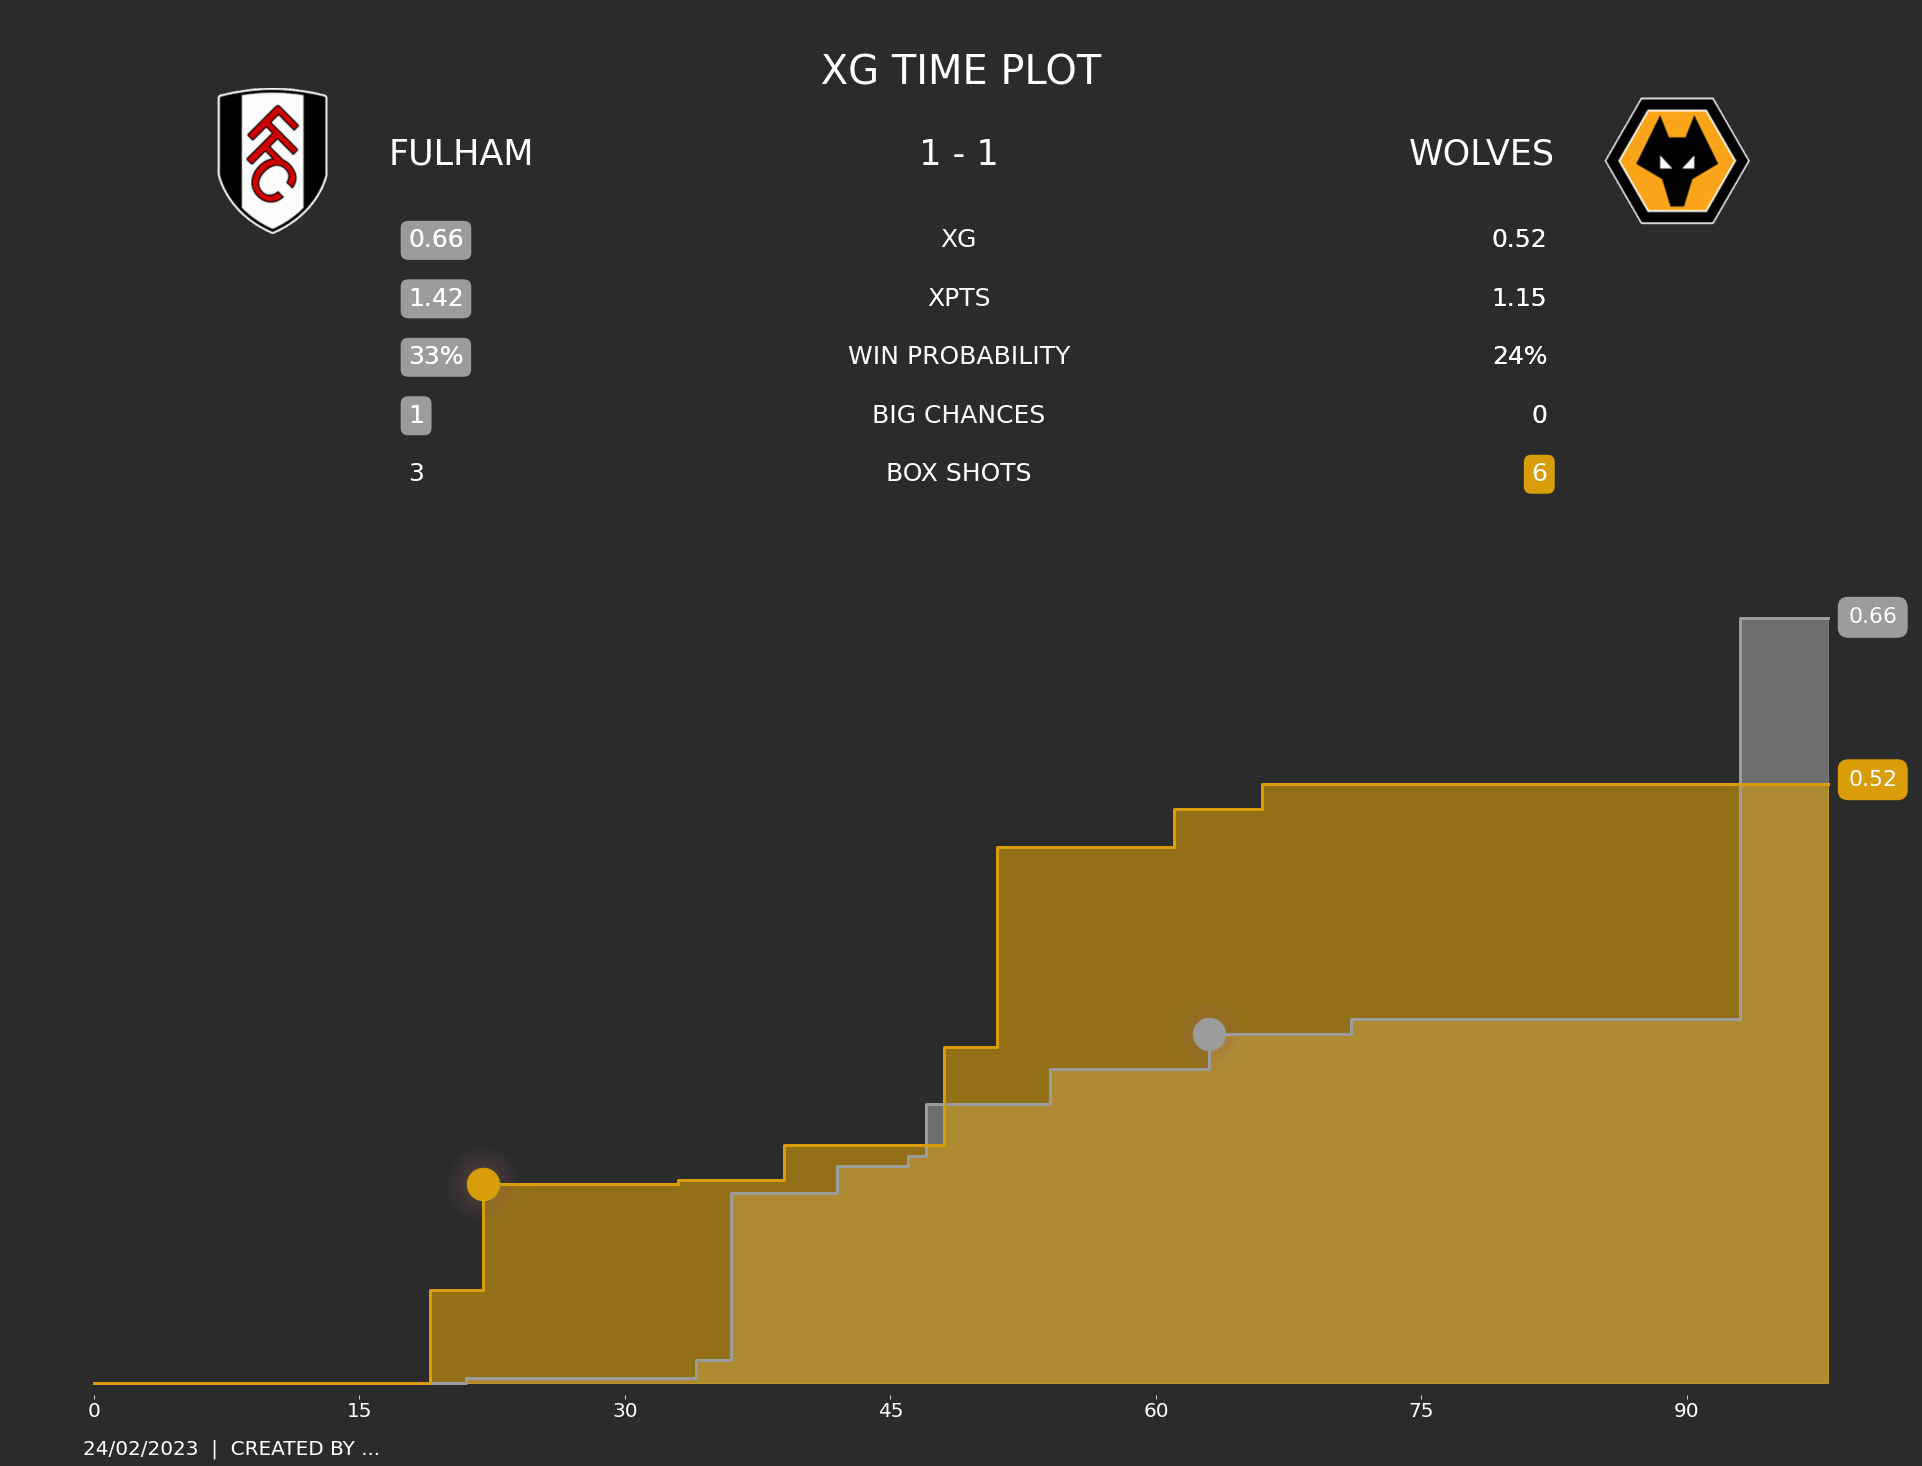

In [30]:
#### import mplcyberpunk
# plt.style.use("cyberpunk")

fig, ax = plt.subplots(figsize = (20,15))
fig.set_facecolor("#2B2B2B")
ax.patch.set_facecolor("#2B2B2B")

plt.xticks([0, 15, 30, 45, 60, 75, 90])
ax.axes.get_yaxis().set_visible(False)
ax.tick_params(axis='x', colors='white')

ax.step(x=xg_moving_h.minute, y=xg_moving_h.cumSum, color=home_color, where='post', lw=3)
ax.step(x=xg_moving_a.minute, y=xg_moving_a.cumSum, color=away_color, where='post', lw=3)
ax.set_ylim(ymin=-0.01)
# ax.grid(ls='--', color='darkgrey')
# ax.fill_between(xg_moving_h.minute, xg_moving_h.cumSum, xg_moving_a.cumSum, color='b', alpha=0.3, 
#                 where=xg_moving_h.cumSum < xg_moving_a.cumSum)

ax.fill_between(x=xg_moving_h.minute,y1=0, y2=xg_moving_h['cumSum'].tolist(), color=home_color, step='post', 
                 alpha=0.6)
ax.fill_between(x=xg_moving_a.minute,y1=0, y2=xg_moving_a['cumSum'].tolist(), color=away_color, step='post', 
                 alpha=0.6)


end_minute = xg_moving_h['minute'][len(xg_moving_h)-1]
end_h_xg =  round(xg_moving_h['cumSum'][len(xg_moving_h)-1],2)

ax.annotate(text=str(end_h_xg), xytext=(end_minute+2.5, end_h_xg), xy=(0, 0), ha='center', va='center', color='white',
                     bbox=dict(facecolor=home_color, edgecolor='#2B2B2B', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=22)


end_minute = xg_moving_a['minute'][len(xg_moving_a)-1]
end_a_xg =  round(xg_moving_a['cumSum'][len(xg_moving_a)-1],2)

ax.annotate(text=str(end_a_xg), xytext=(end_minute+2.5, end_a_xg), xy=(0, 0), ha='center', va='center', color='white',
                     bbox=dict(facecolor=away_color, edgecolor='#2B2B2B', boxstyle='round,pad=.5'),
                     fontname = 'Sans Serif', fontsize=22)


plt.title(" \n xG Time Plot ".upper() , fontname='Sans Serif', color='white', fontsize=40, loc='center', y=1.6, x=0.5)

# ax.annotate(text=home_name.upper() , xytext=(20, 2.15), xy=(0,0), ha='left', color='white', 
#             fontname='Sans Serif', fontsize=35)
# ax.annotate(text=score , xytext=(50, 2.15), xy=(0,0), ha='center', color='white', 
#             fontname='Sans Serif', fontsize=35)
# ax.annotate(text=away_name.upper() , xytext=(80, 2.15), xy=(0,0), ha='right', color='white', 
#             fontname='Sans Serif', fontsize=35)

plt.figtext(0.1775, 0.07, date_str.upper() + '  |  ' + "CREATED BY ...", ha="left", fontsize=20, fontname='Sans Serif', color='white')


for i in range(len(home_goals)):
    minute = home_goals['minute'][i]
    y = home_goals['cumSum'][i]
    ax.scatter(minute, y, marker='o', color=home_color, s=1050, zorder=3)
    mplcyberpunk.make_scatter_glow()
    

for i in range(len(away_goals)):
    minute = away_goals['minute'][i]
    y = away_goals['cumSum'][i]
    ax.scatter(minute, y, marker='o', color=away_color, s=1050, zorder=3)
    mplcyberpunk.make_scatter_glow()


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.grid(False)

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
team_logos = away_logo_code
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos:.0f}.png'))
newax = fig.add_axes([1.2, 1.2, 0.135, 0.135], anchor='NE', zorder=2)
newax.imshow(club_icon)
newax.axis('off')
newax.annotate(text=away_name.upper() , xytext=(-65, 100), xy=(0,0), ha='right', color='white', 
               fontname='Sans Serif', fontsize=35)
newax.annotate(text=score , xytext=(-850, 100), xy=(0,0), ha='center', color='white', 
               fontname='Sans Serif', fontsize=35)

y=200
for metric, home, away in metrics:
    if isinstance(home,int) or isinstance(home,np.float32) or isinstance(home,float):
        home2 = home
        
    if isinstance(away,int) or isinstance(away,np.float32) or isinstance(away,float):
        away2 = away
    
    if isinstance(home,str):
        home2 = home[:]
        home = home.replace('%', '')

    if isinstance(away, str):
        away2 = away[:]
        away = away.replace('%', '')
    
    color_box = ''
    if float(home)>float(away):
        color_box = home_color
    elif float(home)<float(away):
        color_box = away_color
    else:
        color_box = ''
        
    newax.annotate(text=metric.upper(), 
                          xytext=(-850, y), xy=(0, 0), ha='center', va='center', color='white',
                     fontname = 'Sans Serif', fontsize=25)
    
        
    if color_box == home_color: 
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                         bbox=dict(facecolor=home_color, edgecolor='none', boxstyle='round,pad=.3'),
                         fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y),xy=(0, 0), ha='right', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)

        
    if color_box == away_color:
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                     fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y), xy=(0, 0), ha='right', va='center', color='white',
                        bbox=dict(facecolor=away_color, edgecolor='none', boxstyle='round,pad=.3'),
                         fontname = 'Sans Serif', fontsize=25)
        
        
    else:
        newax.annotate(text=str(home2), xytext=(-1575,y), xy=(0, 0), ha='left', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)
        newax.annotate(text=str(away2), xytext=(-75,y), xy=(0, 0), ha='right', va='center', color='white',
                         fontname = 'Sans Serif', fontsize=25)
    y += 77







team_logos2 = home_logo_code
club_icon2 = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_logos2:.0f}.png'))
newax2 = fig.add_axes([0.225, 1.2, 0.135, 0.135], anchor='NE', zorder=2)
newax2.imshow(club_icon2)
newax2.axis('off')
newax.annotate(text=home_name.upper() , xytext=(-1600.25, 100), xy=(0,0), ha='left', color='white', 
               fontname='Sans Serif', fontsize=35)

fig.subplots_adjust(right=1.45) # or whatever
ax.tick_params(axis='both', which='major', labelsize=20)


fig.savefig('xgplot.png', 
            bbox_inches="tight",
            edgecolor="none",
            facecolor = "#2B2B2B",
            dpi=300)